In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pickle
from epftoolbox.data import read_data
from copy import copy
from epftoolbox.evaluation import MAE, rMAE, RMSE, sMAPE
from scipy import stats
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
markers = ['o', 's', '^', 'd']
linestyles=['-', '--']
colors_css = [mcolors.CSS4_COLORS['darkblue'], mcolors.CSS4_COLORS['firebrick'], mcolors.CSS4_COLORS['deepskyblue'], mcolors.CSS4_COLORS['lightcoral']]

In [3]:
def DM(p_real, p_pred_1, p_pred_2, norm=1, version='univariate'):
    """Function that performs the one-sided DM test in the contex of electricity price forecasting
    
    The test compares whether there is a difference in predictive accuracy between two forecast 
    ``p_pred_1`` and ``p_pred_2``. Particularly, the one-sided DM test evaluates the null hypothesis H0 
    of the forecasting errors of  ``p_pred_2`` being larger (worse) than the forecasting
    errors ``p_pred_1`` vs the alternative hypothesis H1 of the errors of ``p_pred_2`` being smaller (better).
    Hence, rejecting H0 means that the forecast ``p_pred_2`` is significantly more accurate
    that forecast ``p_pred_1``. (Note that this is an informal definition. For a formal one we refer to 
    `here <https://epftoolbox.readthedocs.io/en/latest/modules/cite.html>`_)

    Two versions of the test are possible:

        1. A univariate version with as many independent tests performed as prices per day, i.e. 24
        tests in most day-ahead electricity markets.

        2. A multivariate with the test performed jointly for all hours using the multivariate 
        loss differential series (see this 
        `article <https://epftoolbox.readthedocs.io/en/latest/modules/cite.html>`_ for details.

    
    Parameters
    ----------
    p_real : numpy.ndarray
        Array of shape :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})` representing the real market
        prices
    p_pred_1 : TYPE
        Array of shape :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})` representing the first forecast
    p_pred_2 : TYPE
        Array of shape :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})` representing the second forecast
    norm : int, optional
        Norm used to compute the loss differential series. At the moment, this value must either
        be 1 (for the norm-1) or 2 (for the norm-2).
    version : str, optional
        Version of the test as defined in 
        `here <https://epftoolbox.readthedocs.io/en/latest/modules/cite.html>`_. It can have two values:
        ``'univariate`` or ``'multivariate``      
    Returns
    -------
    float, numpy.ndarray
        The p-value after performing the test. It is a float in the case of the multivariate test
        and a numpy array with a p-value per hour for the univariate test

    Example
    -------
    >>> from epftoolbox.evaluation import DM
    >>> from epftoolbox.data import read_data
    >>> import pandas as pd
    >>> 
    >>> # Generating forecasts of multiple models
    >>> 
    >>> # Download available forecast of the NP market available in the library repository
    >>> # These forecasts accompany the original paper
    >>> forecasts = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' + 
    ...                       'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
    >>> 
    >>> # Deleting the real price field as it the actual real price and not a forecast
    >>> del forecasts['Real price']
    >>> 
    >>> # Transforming indices to datetime format
    >>> forecasts.index = pd.to_datetime(forecasts.index)
    >>> 
    >>> # Extracting the real prices from the market
    >>> _, df_test = read_data(path='.', dataset='NP', begin_test_date=forecasts.index[0], 
    ...                        end_test_date=forecasts.index[-1])
    Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00
    >>> 
    >>> real_price = df_test.loc[:, ['Price']]
    >>> 
    >>> # Testing the univariate DM version on an ensemble of DNN models versus an ensemble
    >>> # of LEAR models
    >>> DM(p_real=real_price.values.reshape(-1, 24), 
    ...     p_pred_1=forecasts.loc[:, 'LEAR Ensemble'].values.reshape(-1, 24), 
    ...     p_pred_2=forecasts.loc[:, 'DNN Ensemble'].values.reshape(-1, 24), 
    ...     norm=1, version='univariate')
    array([9.99999944e-01, 9.97562415e-01, 8.10333949e-01, 8.85201928e-01,
           9.33505978e-01, 8.78116764e-01, 1.70135981e-02, 2.37961920e-04,
           5.52337353e-04, 6.07843340e-05, 1.51249750e-03, 1.70415008e-03,
           4.22319907e-03, 2.32808010e-03, 3.55958698e-03, 4.80663621e-03,
           1.64841032e-04, 4.55829140e-02, 5.86609688e-02, 1.98878375e-03,
           1.04045731e-01, 8.71203187e-02, 2.64266732e-01, 4.06676195e-02])
    >>> 
    >>> # Testing the multivariate DM version
    >>> DM(p_real=real_price.values.reshape(-1, 24), 
    ...     p_pred_1=forecasts.loc[:, 'LEAR Ensemble'].values.reshape(-1, 24), 
    ...     p_pred_2=forecasts.loc[:, 'DNN Ensemble'].values.reshape(-1, 24), 
    ...     norm=1, version='multivariate')
    0.003005725748326471
    """

    # Checking that all time series have the same shape
    if p_real.shape != p_pred_1.shape or p_real.shape != p_pred_2.shape:
        raise ValueError('The three time series must have the same shape')

    # Ensuring that time series have shape (n_days, n_prices_day)
    if len(p_real.shape) == 1 or (len(p_real.shape) == 2 and p_real.shape[1] == 1):
        raise ValueError('The time series must have shape (n_days, n_prices_day')

    # Computing the errors of each forecast
    errors_pred_1 = p_real - p_pred_1
    errors_pred_2 = p_real - p_pred_2

    # Computing the test statistic
    if version == 'univariate':

        # Computing the loss differential series for the univariate test
        if norm == 1:
            d = np.abs(errors_pred_1) - np.abs(errors_pred_2)
        if norm == 2:
            d = errors_pred_1**2 - errors_pred_2**2

        # Computing the loss differential size
        N = d.shape[0]

        # Computing the test statistic
        mean_d = np.mean(d, axis=0)
        var_d = np.var(d, ddof=0, axis=0)
        DM_stat = mean_d / np.sqrt((1 / N) * var_d)

    elif version == 'multivariate':

        # Computing the loss differential series for the multivariate test
        if norm == 1:
            d = np.mean(np.abs(errors_pred_1), axis=1) - np.mean(np.abs(errors_pred_2), axis=1)
        if norm == 2:
            d = np.mean(errors_pred_1**2, axis=1) - np.mean(errors_pred_2**2, axis=1)

        # Computing the loss differential size
        N = d.size

        # Computing the test statistic
        mean_d = np.mean(d)
        var_d = np.var(d, ddof=0)
        DM_stat = mean_d / np.sqrt((1 / N) * var_d)
        
    p_value = 1 - stats.norm.cdf(DM_stat)

    return p_value

In [4]:
def plot_multivariate_DM_test(real_price, forecasts, norm=1, title='DM test', savefig=False, path=''):
    import matplotlib as mpl
    """Plotting the results of comparing forecasts using the multivariate DM test. 
    
    The resulting plot is a heat map in a chessboard shape. It represents the p-value
    of the null hypothesis of the forecast in the y-axis being significantly more
    accurate than the forecast in the x-axis. In other words, p-values close to 0
    represent cases where the forecast in the x-axis is significantly more accurate
    than the forecast in the y-axis.
    
    Parameters
    ----------
    real_price : pandas.DataFrame
        Dataframe that contains the real prices
    forecasts : TYPE
        Dataframe that contains the forecasts of different models. The column names are the 
        forecast/model names. The number of datapoints should equal the number of datapoints
        in ``real_price``.
    norm : int, optional
        Norm used to compute the loss differential series. At the moment, this value must either
        be 1 (for the norm-1) or 2 (for the norm-2).
    title : str, optional
        Title of the generated plot
    savefig : bool, optional
        Boolean that selects whether the figure should be saved in the current folder
    path : str, optional
        Path to save the figure. Only necessary when `savefig=True`
    
    Example
    -------
    >>> from epftoolbox.evaluation import DM, plot_multivariate_DM_test
    >>> from epftoolbox.data import read_data
    >>> import pandas as pd
    >>> 
    >>> # Generating forecasts of multiple models
    >>> 
    >>> # Download available forecast of the NP market available in the library repository
    >>> # These forecasts accompany the original paper
    >>> forecasts = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' + 
    ...                       'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
    >>> 
    >>> # Deleting the real price field as it the actual real price and not a forecast
    >>> del forecasts['Real price']
    >>> 
    >>> # Transforming indices to datetime format
    >>> forecasts.index = pd.to_datetime(forecasts.index)
    >>> 
    >>> # Extracting the real prices from the market
    >>> _, df_test = read_data(path='.', dataset='NP', begin_test_date=forecasts.index[0], 
    ...                        end_test_date=forecasts.index[-1])
    Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00
    >>> 
    >>> real_price = df_test.loc[:, ['Price']]
    >>> 
    >>> # Generating a plot to compare the models using the multivariate DM test
    >>> plot_multivariate_DM_test(real_price=real_price, forecasts=forecasts)
    
    """

    # Computing the multivariate DM test for each forecast pair
    p_values = pd.DataFrame(index=forecasts.columns, columns=forecasts.columns) 

    for model1 in forecasts.columns:
        for model2 in forecasts.columns:
            # For the diagonal elemnts representing comparing the same model we directly set a 
            # p-value of 1
            if model1 == model2:
                p_values.loc[model1, model2] = 1
            else:
                p_values.loc[model1, model2] = DM(p_real=real_price.values.reshape(-1, 24), 
                                                  p_pred_1=forecasts.loc[:, model1].values.reshape(-1, 24), 
                                                  p_pred_2=forecasts.loc[:, model2].values.reshape(-1, 24), 
                                                  norm=norm, version='multivariate')

    # Defining color map
    red = np.concatenate([np.linspace(0, 1, 50), np.linspace(1, 0.5, 50)[1:], [0]])
    green = np.concatenate([np.linspace(0.5, 1, 50), np.zeros(50)])
    blue = np.zeros(100)
    rgb_color_map = np.concatenate([red.reshape(-1, 1), green.reshape(-1, 1), 
                                    blue.reshape(-1, 1)], axis=1)
    rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

    # Generating figure
    plt.figure(figsize = (8, 8))
    plt.imshow(p_values.astype(float).values, cmap=rgb_color_map, vmin=0, vmax=0.1)
    plt.xticks(range(len(forecasts.columns)), forecasts.columns, rotation=90.)
    plt.yticks(range(len(forecasts.columns)), forecasts.columns)
    for i in range(1, len(forecasts.columns)):
        plt.axvline(x=i - 0.5, ls='--', color='white', linewidth=1)
        plt.axhline(y=i - 0.5, ls='--', color='white', linewidth=1)
        
    plt.plot(range(p_values.shape[0]), range(p_values.shape[0]), 'wx')
    plt.colorbar()
    plt.title(title)
    plt.grid()
    plt.tight_layout()

    if savefig:
        plt.savefig(title + '.png', dpi=300)
        plt.savefig(title + '.eps')

    plt.show()

In [5]:
dict_datastets_forecasts = {}

datasets = ["SP_2023.csv", "DE_2023.csv", "BE.csv", "FR.csv", "NP.csv"]
apply_adaptive_standardisation_list = [True, False]
calibration_windows_1 = [56, 84, 1092, 1456]
calibration_windows_2 = [56, 84, 364, 728]
experiment_ids = range(1, 5)
models = ['LEAR', 'DNN']
# models = ['LEAR']

for dataset in datasets:
    df = pd.read_csv(f"Data//{dataset}")
    df['Date'] = pd.to_datetime(df.Date)
    df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2']
    df = df.drop(['Exogenous 1', 'Exogenous 2'], axis = 1)
    for model in models:
        if dataset in ["BE.csv", "FR.csv", "NP.csv"]:
            if model =='LEAR':
                calibration_windows = calibration_windows_1
            else:
                calibration_windows = experiment_ids
        elif dataset in ["DE_2023.csv", "SP_2023.csv"]:
            if model =='LEAR':
                calibration_windows = calibration_windows_2
            else:
                calibration_windows = experiment_ids

        if dataset in ["BE.csv", "FR.csv"]:
            begin_test_date = "04/01/2015 00:00"
            end_test_date = "31/12/2016 23:00"

        elif dataset in ["DE_2023.csv", "SP_2023.csv"] :
            begin_test_date = "01/01/2022 00:00"
            end_test_date = "31/05/2023 23:00"

        elif dataset in ["NP.csv"] :
            begin_test_date = "27/12/2016 00:00"
            end_test_date = "24/12/2018 23:00"


        for apply_adaptive_standardisation in apply_adaptive_standardisation_list:
            for calibration_window in calibration_windows:
                if apply_adaptive_standardisation:
                    if model == "LEAR":
                        file_name = f"dataset_{dataset.replace('.csv', '_no_outliers')}model_LEAR_as_calibration_window{calibration_window}.csv"
                    else:
                        file_name = f"dataset_{dataset.replace('.csv', '_no_outliers')}model_DNN_as_calibration_window_None_experiment_id_{calibration_window}.csv"        
                else:
                    if model == "LEAR":
                        file_name = f"dataset_{dataset.replace('.csv', '')}model_LEAR_calibration_window{calibration_window}.csv"
                    else:
                        if dataset in ["BE.csv", "FR.csv", "NP.csv"]:
                            file_name = f"dataset_{dataset.replace('.csv', '')}model_DNN_calibration_window_4_experiment_id_{calibration_window}.csv"
                        else:
                            file_name = f"dataset_{dataset.replace('.csv', '')}model_DNN_calibration_window_3_experiment_id_{calibration_window}.csv"

                forecasts = pd.read_csv("Results_py//"+file_name, index_col=0).to_numpy().reshape(-1)
                if model == 'LEAR':
                    df.loc[df.tail(len(forecasts)).index, f'{"LEAR"}_calibration_window_{str(calibration_window).replace("_", "")}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                else:
                    if apply_adaptive_standardisation:
                        df.loc[df.tail(len(forecasts)).index, f'{"DNN"}_calibration_window_None_experiment_id_{str(calibration_window)}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                    else:
                        if dataset in ["BE.csv", "FR.csv", "NP.csv"]:
                            df.loc[df.tail(len(forecasts)).index, f'{"DNN"}_calibration_window_4_experiment_id_{str(calibration_window)}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                        else:
                            df.loc[df.tail(len(forecasts)).index, f'{"DNN"}_calibration_window_3_experiment_id_{str(calibration_window)}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts

            if apply_adaptive_standardisation and model == 'LEAR':
                file_name = f"dataset_{dataset.replace('.csv', '_no_outliers')}model_LEAR_as_calibration_window_{None}.csv"
    #             try:
                forecasts = pd.read_csv("Results_py//"+file_name, index_col=0).to_numpy().reshape(-1)
    #             except:
    #                 print(file_name)
    #                 forecasts = pd.read_csv(r"C:\Users\csebastian\Desktop\CARIBE\Results_py\dataset_NPmodel_LEAR_as_calibration_window_None.csv", index_col=0).to_numpy().reshape(-1)
                df.loc[df.tail(len(forecasts)).index, f'{"LEAR"}_calibration_window_{str(None).replace("_", "")}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
            elif not apply_adaptive_standardisation and model == 'LEAR':
                file_name = f"dataset_{dataset.replace('.csv', '')}model_LEAR_calibration_window_{None}.csv"
                try:
                    forecasts = pd.read_csv("Results_py//"+file_name, index_col=0).to_numpy().reshape(-1)
                except:
                    print(file_name)
                    forecasts = pd.read_csv(r"C:\Users\csebastian\Desktop\CARIBE\Results_py\dataset_NPmodel_LEAR_as_calibration_window_None.csv", index_col=0).to_numpy().reshape(-1)
                df.loc[df.tail(len(forecasts)).index, f'{"LEAR"}_calibration_window_{str(None).replace("_", "")}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts

    columns_ensemble_1_LEAR = [col for col in df.columns if ('True' in col and 'LEAR' in col)]
    columns_ensemble_2_LEAR = [col for col in df.columns if ('False' in col and 'LEAR' in col)]
    columns_ensemble_3_LEAR = [col for col in df.columns if ('True' in col and 'LEAR' in col and '56' not in col and '84' not in col)]

#     df['LEAR_ensemble_adaptive_standardisation_True'] = df[columns_ensemble_1_LEAR].mean(axis=1)
    df['LEAR_ensemble_adaptive_standardisation_False'] = df[columns_ensemble_2_LEAR].mean(axis=1)
    df['LEAR_ensemble_adaptive_standardisation_True'] = df[columns_ensemble_3_LEAR].mean(axis=1)

    columns_ensemble_1_DNN = [col for col in df.columns if ('True' in col and 'DNN' in col)]
    columns_ensemble_2_DNN = [col for col in df.columns if ('False' in col and 'DNN' in col)]

    df['DNN_ensemble_adaptive_standardisation_True'] = df[columns_ensemble_1_DNN].mean(axis=1)
    df['DNN_ensemble_adaptive_standardisation_False'] = df[columns_ensemble_2_DNN].mean(axis=1)
    
    df['LEAR_all_ensemble'] = df[['LEAR_ensemble_adaptive_standardisation_False', 'LEAR_ensemble_adaptive_standardisation_True']].mean(axis=1)
    df['DNN_all_ensemble'] = df[['DNN_ensemble_adaptive_standardisation_True', 'DNN_ensemble_adaptive_standardisation_False']].mean(axis=1)

    
    dict_datastets_forecasts[dataset] = df.dropna()
    
        
        

In [6]:
dict_datasets_results={}
for dataset in datasets:
# for dataset in ['SP_2023.csv']:
    df = dict_datastets_forecasts[dataset]
    models = [col for col in df.columns if col not in ['Date', 'Price']]
    dict_datasets_results[dataset] = pd.DataFrame(columns= models)
    
    real_values = df.set_index(pd.DatetimeIndex(df.Date)).loc[:, ['Price']].values.reshape(-1, 24)
    real_values = pd.DataFrame(real_values, index=pd.DatetimeIndex(df.Date)[::24], columns=['h' + str(k) for k in range(24)])
    
    maes = []
    rmses = []
    smapes = []
    rmaes = []
    
    for model in models:
        
        forecasts_matrix = df.set_index(pd.DatetimeIndex(df.Date)).loc[:, [model]].values.reshape(-1, 24)
        forecasts_matrix = pd.DataFrame(forecasts_matrix, index=pd.DatetimeIndex(df.Date)[::24], columns=['h' + str(k) for k in range(24)])
        
        maes.append(MAE(df.Price, df[model]))
        rmses.append(RMSE(df.Price, df[model]))
        smapes.append(sMAPE(df.Price, df[model]))
        rmaes.append(rMAE(real_values, forecasts_matrix, m='W'))
    
    dict_datasets_results[dataset].loc['MAE', :] = maes
    dict_datasets_results[dataset].loc['RMSE', :] = rmses
    dict_datasets_results[dataset].loc['sMAPE', :] = smapes
    dict_datasets_results[dataset].loc['rMAE', :] = rmaes

In [7]:
pd.set_option('display.max_columns', 25)

# OMIE-SP

In [104]:
dict_datasets_results['SP_2023.csv']

,LEAR_calibration_window_56_adaptive_standardisation_True,LEAR_calibration_window_84_adaptive_standardisation_True,LEAR_calibration_window_364_adaptive_standardisation_True,LEAR_calibration_window_728_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_56_adaptive_standardisation_False,LEAR_calibration_window_84_adaptive_standardisation_False,LEAR_calibration_window_364_adaptive_standardisation_False,LEAR_calibration_window_728_adaptive_standardisation_False,LEAR_calibration_window_None_adaptive_standardisation_False,DNN_calibration_window_None_experiment_id_1_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_2_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_3_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_4_adaptive_standardisation_True,DNN_calibration_window_3_experiment_id_1_adaptive_standardisation_False,DNN_calibration_window_3_experiment_id_2_adaptive_standardisation_False,DNN_calibration_window_3_experiment_id_3_adaptive_standardisation_False,DNN_calibration_window_3_experiment_id_4_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_False,LEAR_all_ensemble,DNN_all_ensemble
MAE,21.74534,20.354119,18.676508,18.479818,18.272909,21.025286,20.860755,19.396855,19.458501,20.685086,18.187928,18.0954,17.867425,17.67246,22.377145,19.236778,23.370452,20.78928,18.096508,18.113523,17.291171,19.597126,17.299642,17.330291
RMSE,32.306051,29.255491,26.778778,26.178458,25.934085,30.661416,31.086855,27.959864,27.568709,29.275025,26.007717,26.11978,25.311671,25.109331,31.819256,27.456201,32.964229,30.154811,25.938794,25.85532,24.696471,28.597325,24.760186,25.22689
sMAPE,0.233857,0.223241,0.21005,0.212692,0.214422,0.225947,0.226599,0.216094,0.219494,0.219592,0.212672,0.206896,0.206014,0.207032,0.234376,0.207252,0.239654,0.216824,0.203878,0.207126,0.202471,0.209839,0.19786,0.194131
rMAE,0.567837,0.531508,0.4877,0.482564,0.477161,0.549034,0.544738,0.506511,0.508121,0.540151,0.474942,0.472526,0.466573,0.461482,0.584335,0.502331,0.610274,0.542871,0.472555,0.472999,0.451525,0.511741,0.451746,0.452547


In [105]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['SP_2023.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['SP_2023.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['SP_2023.csv'][dict_datastets_forecasts['SP_2023.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

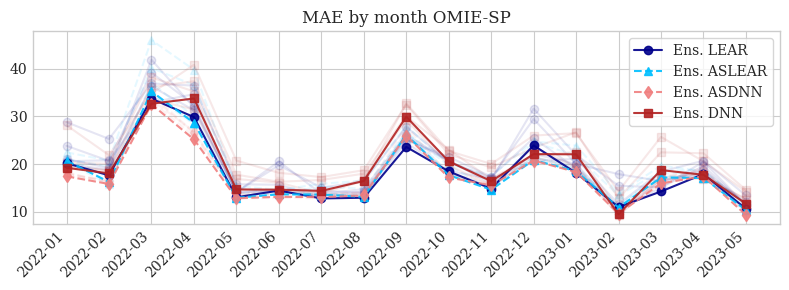

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
        
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':6})
ax.legend(frameon=True)
ax.title.set_text("MAE by month OMIE-SP")
ax.title.set_size(12)
fig.autofmt_xdate(rotation=45)
plt.tight_layout()

In [107]:
fig.savefig("mae_by_month_omie_sp.png", dpi=300)

In [108]:
models_dm = ['ASLEAR$_{56}$', 'ASLEAR$_{84}$', 'ASLEAR$_{364}$', 'ASLEAR$_{728}$', 'ASLEAR$_{All}$', 'LEAR$_{56}$', 'LEAR$_{84}$', 'LEAR$_{364}$', 'LEAR$_{728}$', 'LEAR$_{All}$', 'ASDNN$_1$', 'ASDNN$_2$', 'ASDNN$_3$', 'ASDNN$_4$', 'DNN$_1$', 'DNN$_2$', 'DNN$_3$', 'DNN$_4$', 'Ensemble ASLEAR', 'Ensemble LEAR', 'Ensemble ASDNN', 'Ensemble DNN', 'Ensemble LEAR-ASLEAR', 'Ensemble DNN-ASDNN']

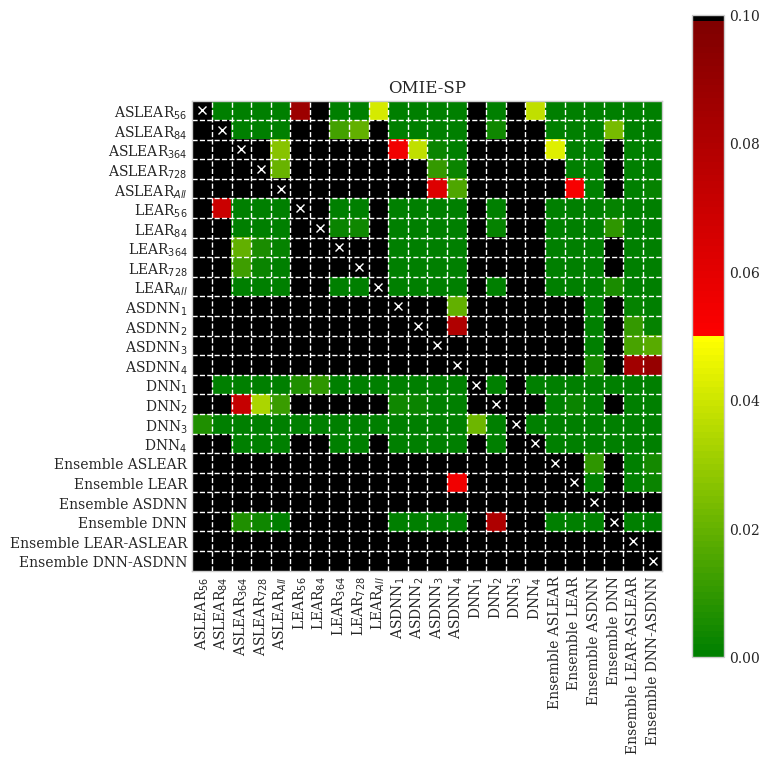

In [109]:
models = [col for col in dict_datastets_forecasts['SP_2023.csv'] if col not in ['Date', 'Price']]
df_aux = dict_datastets_forecasts['SP_2023.csv'][models]
df_aux.columns = models_dm
plot_multivariate_DM_test(dict_datastets_forecasts['SP_2023.csv'].Price, 
                          df_aux, 
                          norm=1, 
                          title='OMIE-SP', 
                          savefig=True, 
                          path=r'C:\Users\csebastian\Desktop\CARIBE')

# EPEX-DE

In [110]:
dict_datasets_results['DE_2023.csv']

,LEAR_calibration_window_56_adaptive_standardisation_True,LEAR_calibration_window_84_adaptive_standardisation_True,LEAR_calibration_window_364_adaptive_standardisation_True,LEAR_calibration_window_728_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_56_adaptive_standardisation_False,LEAR_calibration_window_84_adaptive_standardisation_False,LEAR_calibration_window_364_adaptive_standardisation_False,LEAR_calibration_window_728_adaptive_standardisation_False,LEAR_calibration_window_None_adaptive_standardisation_False,DNN_calibration_window_None_experiment_id_1_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_2_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_3_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_4_adaptive_standardisation_True,DNN_calibration_window_3_experiment_id_1_adaptive_standardisation_False,DNN_calibration_window_3_experiment_id_2_adaptive_standardisation_False,DNN_calibration_window_3_experiment_id_3_adaptive_standardisation_False,DNN_calibration_window_3_experiment_id_4_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_False,LEAR_all_ensemble,DNN_all_ensemble
MAE,29.715751,28.7634,26.470278,25.99141,25.648844,31.421519,30.445711,30.674826,28.538553,31.126594,26.276362,25.921211,24.346088,26.259435,27.214226,25.607126,26.184134,26.830324,25.978269,25.520524,23.908885,23.692837,23.838506,22.099109
RMSE,44.666329,42.686878,39.13551,38.645975,38.107131,47.313783,44.988947,42.520381,40.597177,44.601608,38.750173,38.36696,36.10536,38.699099,39.171219,37.32474,38.139038,38.686534,37.461303,37.985928,35.215459,34.611436,34.888567,32.467717
sMAPE,0.235885,0.232654,0.219795,0.215863,0.21332,0.251532,0.249182,0.253815,0.229045,0.239355,0.21499,0.211131,0.206491,0.211946,0.221284,0.208021,0.215574,0.217176,0.211848,0.212932,0.199449,0.198953,0.199541,0.188908
rMAE,0.412636,0.399412,0.367569,0.36092,0.356163,0.436323,0.422772,0.425954,0.396289,0.432227,0.364876,0.359945,0.338072,0.364641,0.3779,0.355583,0.363596,0.372569,0.360737,0.354381,0.332001,0.329001,0.331024,0.306871


In [111]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['DE_2023.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['DE_2023.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['DE_2023.csv'][dict_datastets_forecasts['DE_2023.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

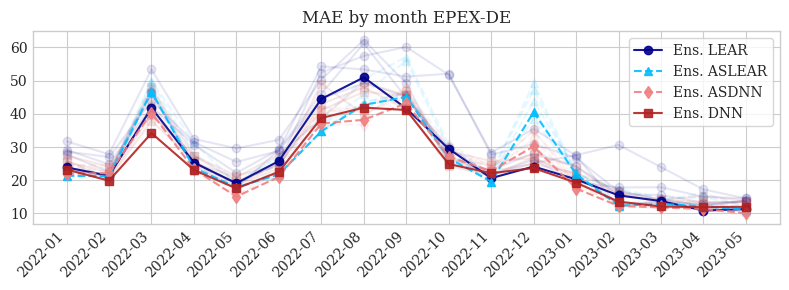

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
        
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':6})
ax.legend(frameon=True)
ax.title.set_text("MAE by month EPEX-DE")
ax.title.set_size(12)
fig.autofmt_xdate(rotation=45)
plt.tight_layout()

In [113]:
fig.savefig("mae_by_month_epex_de.png", dpi=300)

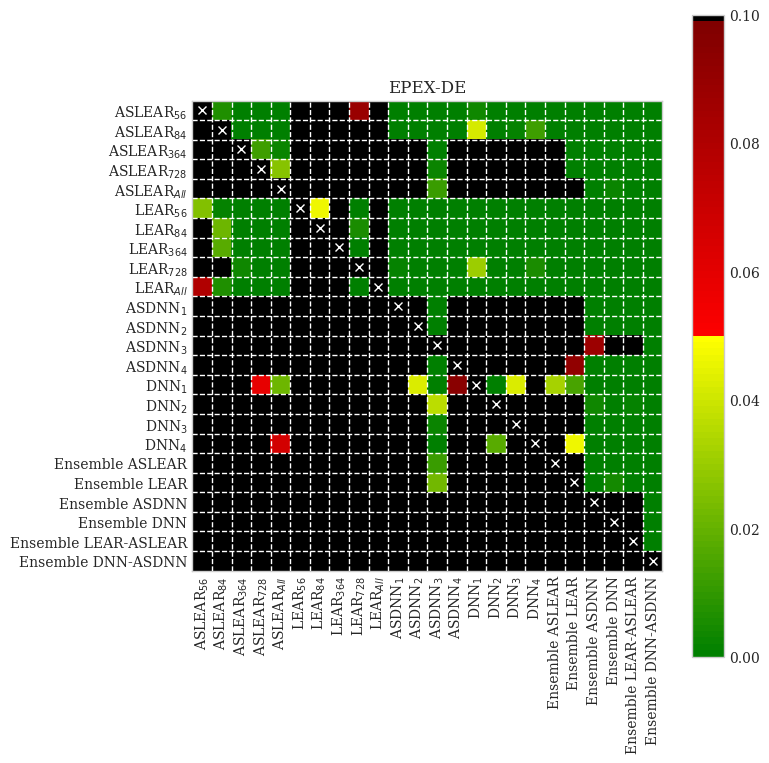

In [114]:
models = [col for col in dict_datastets_forecasts['DE_2023.csv'] if col not in ['Date', 'Price']]
df_aux = dict_datastets_forecasts['DE_2023.csv'][models]
df_aux.columns = models_dm
plot_multivariate_DM_test(dict_datastets_forecasts['DE_2023.csv'].Price, 
                          df_aux, 
                          norm=1, 
                          title='EPEX-DE', 
                          savefig=True, 
                          path=r'C:\Users\csebastian\Desktop\CARIBE')

# EPEX-BE

In [115]:
dict_datasets_results["BE.csv"]

,LEAR_calibration_window_56_adaptive_standardisation_True,LEAR_calibration_window_84_adaptive_standardisation_True,LEAR_calibration_window_1092_adaptive_standardisation_True,LEAR_calibration_window_1456_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_56_adaptive_standardisation_False,LEAR_calibration_window_84_adaptive_standardisation_False,LEAR_calibration_window_1092_adaptive_standardisation_False,LEAR_calibration_window_1456_adaptive_standardisation_False,LEAR_calibration_window_None_adaptive_standardisation_False,DNN_calibration_window_None_experiment_id_1_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_2_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_3_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_4_adaptive_standardisation_True,DNN_calibration_window_4_experiment_id_1_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_2_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_3_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_4_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_False,LEAR_all_ensemble,DNN_all_ensemble
MAE,8.299087,7.834426,6.854542,6.844537,6.837159,7.026698,6.919593,6.453994,6.451683,6.535129,6.388354,6.583605,6.652881,6.440327,6.292122,6.224985,6.461957,6.419537,6.184318,6.820147,6.308532,6.059176,6.232192,5.949916
RMSE,25.920013,26.163315,17.163319,17.239748,17.239424,16.158389,16.192013,16.511921,16.424156,16.363536,15.888428,16.480652,16.546973,16.205099,16.130091,16.235235,16.630711,16.554009,15.881166,17.15025,16.069751,16.144787,15.850013,15.84394
sMAPE,0.172213,0.166097,0.155811,0.155117,0.154732,0.16544,0.163722,0.156146,0.159616,0.162197,0.149068,0.153363,0.1558,0.151552,0.146232,0.145293,0.149921,0.149334,0.146821,0.154682,0.146751,0.13886,0.143666,0.13635
rMAE,0.81688,0.771144,0.674694,0.673709,0.672983,0.691639,0.681096,0.635268,0.63504,0.643254,0.628807,0.648025,0.654844,0.633922,0.619334,0.612726,0.636051,0.631876,0.608723,0.671308,0.62095,0.596406,0.613435,0.585651


In [116]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['BE.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['BE.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['BE.csv'][dict_datastets_forecasts['BE.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

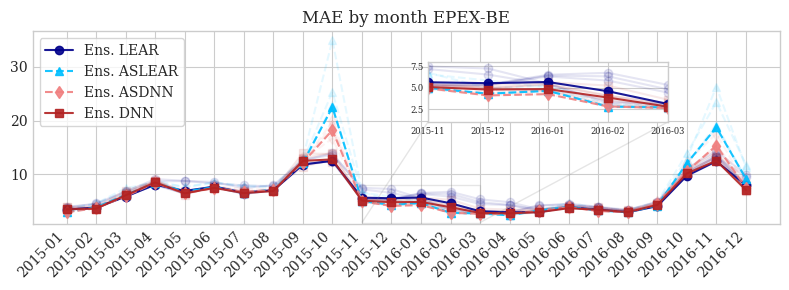

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
        
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':6})
ax.legend(frameon=True)
ax.title.set_text("MAE by month EPEX-BE")
ax.title.set_size(12)
fig.autofmt_xdate(rotation=45)

zoom_start_date = '2015-11'
zoom_end_date = '2016-03'

axins = inset_axes(ax, width='30%', height='20%', bbox_to_anchor=(-0.15,-0.2, 1, 1), bbox_transform=ax.figure.transFigure)
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        axins.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
axins.set_xlim(zoom_start_date, zoom_end_date)
axins.set_ylim(1, 8)
axins.tick_params(axis='both', labelsize=6)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5", alpha=0.2)

plt.tight_layout()

In [138]:
fig.savefig("mae_by_month_epex_be.png", dpi=300)

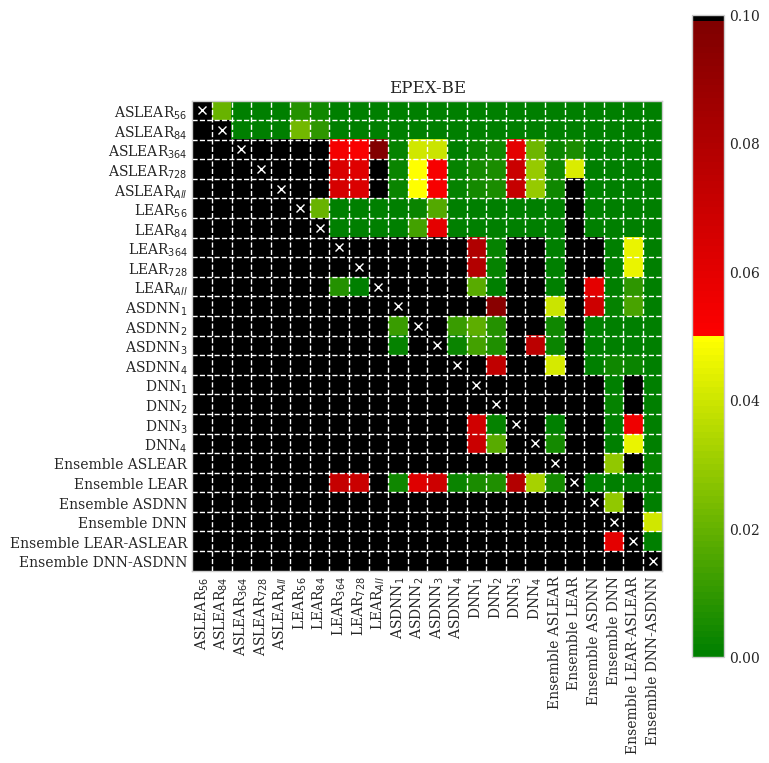

In [139]:
models = [col for col in dict_datastets_forecasts['BE.csv'] if col not in ['Date', 'Price']]
df_aux = dict_datastets_forecasts['BE.csv'][models]
df_aux.columns = models_dm
plot_multivariate_DM_test(dict_datastets_forecasts['BE.csv'].Price, 
                          df_aux, 
                          norm=1, 
                          title='EPEX-BE', 
                          savefig=True, 
                          path=r'C:\Users\csebastian\Desktop\CARIBE')

# EPEX-FR

In [140]:
dict_datasets_results["FR.csv"]

,LEAR_calibration_window_56_adaptive_standardisation_True,LEAR_calibration_window_84_adaptive_standardisation_True,LEAR_calibration_window_1092_adaptive_standardisation_True,LEAR_calibration_window_1456_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_56_adaptive_standardisation_False,LEAR_calibration_window_84_adaptive_standardisation_False,LEAR_calibration_window_1092_adaptive_standardisation_False,LEAR_calibration_window_1456_adaptive_standardisation_False,LEAR_calibration_window_None_adaptive_standardisation_False,DNN_calibration_window_None_experiment_id_1_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_2_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_3_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_4_adaptive_standardisation_True,DNN_calibration_window_4_experiment_id_1_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_2_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_3_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_4_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_False,LEAR_all_ensemble,DNN_all_ensemble
MAE,4.858916,4.691188,4.147002,4.144603,4.190736,4.824439,4.62233,4.212239,4.277453,4.366563,4.083095,4.114878,4.16264,4.166625,4.248788,4.237231,4.228763,4.124873,4.017818,4.143842,3.9374,3.999378,3.902483,3.81357
RMSE,14.29848,14.564127,12.166217,12.242892,12.644643,10.833194,11.490289,11.669696,11.671303,11.666922,11.15839,12.042272,11.897324,11.713217,11.936335,12.141444,11.890841,12.007171,10.94559,12.336792,11.527458,11.865098,11.379895,11.544174
sMAPE,0.129682,0.125428,0.115873,0.115383,0.115457,0.13842,0.134745,0.12691,0.133252,0.13683,0.116612,0.116441,0.118577,0.117633,0.122835,0.11995,0.118564,0.116245,0.118063,0.114975,0.111711,0.11285,0.110881,0.107627
rMAE,0.662738,0.639861,0.565636,0.565309,0.571601,0.658036,0.630469,0.574534,0.583429,0.595583,0.556919,0.561254,0.567769,0.568312,0.579519,0.577943,0.576788,0.562618,0.548016,0.565205,0.537047,0.5455,0.532284,0.520157


In [141]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['FR.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['FR.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['FR.csv'][dict_datastets_forecasts['FR.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

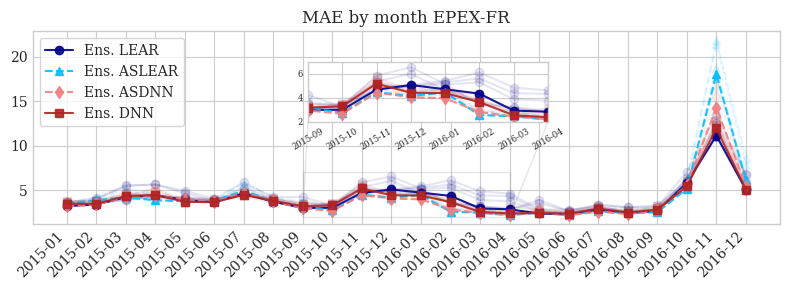

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
        
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':6})
ax.legend(frameon=True)
ax.title.set_text("MAE by month EPEX-FR")
ax.title.set_size(12)
fig.autofmt_xdate(rotation=45)

zoom_start_date = '2015-09'
zoom_end_date = '2016-04'

axins = inset_axes(ax, width='30%', height='20%', bbox_to_anchor=(-0.3,-0.2, 1, 1), bbox_transform=ax.figure.transFigure)
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        axins.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
axins.set_xlim(zoom_start_date, zoom_end_date)
axins.set_ylim(2, 7)
axins.tick_params(axis='both', labelsize=6)
axins.tick_params(axis = 'x',rotation=30)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5", alpha=0.2)

plt.tight_layout()

In [145]:
fig.savefig("mae_by_month_epex_fr.png", dpi=300)

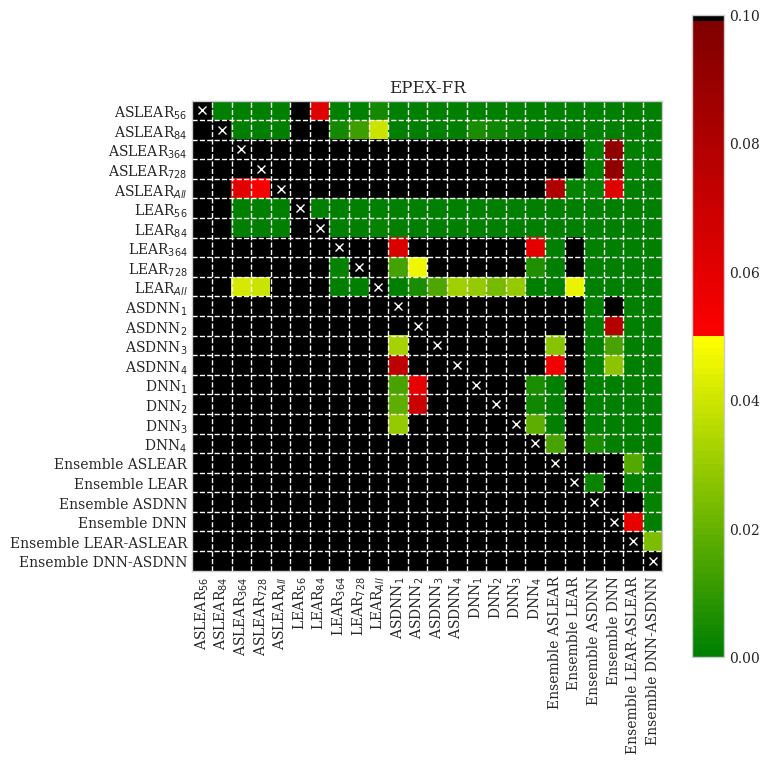

In [147]:
models = [col for col in dict_datastets_forecasts['FR.csv'] if col not in ['Date', 'Price']]
df_aux = dict_datastets_forecasts['FR.csv'][models]
df_aux.columns = models_dm
plot_multivariate_DM_test(dict_datastets_forecasts['FR.csv'].Price, 
                          df_aux, 
                          norm=1, 
                          title='EPEX-FR', 
                          savefig=True, 
                          path=r'C:\Users\csebastian\Desktop\CARIBE')

# NP

In [148]:
dict_datasets_results["NP.csv"]

,LEAR_calibration_window_56_adaptive_standardisation_True,LEAR_calibration_window_84_adaptive_standardisation_True,LEAR_calibration_window_1092_adaptive_standardisation_True,LEAR_calibration_window_1456_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_56_adaptive_standardisation_False,LEAR_calibration_window_84_adaptive_standardisation_False,LEAR_calibration_window_1092_adaptive_standardisation_False,LEAR_calibration_window_1456_adaptive_standardisation_False,LEAR_calibration_window_None_adaptive_standardisation_False,DNN_calibration_window_None_experiment_id_1_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_2_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_3_adaptive_standardisation_True,DNN_calibration_window_None_experiment_id_4_adaptive_standardisation_True,DNN_calibration_window_4_experiment_id_1_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_2_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_3_adaptive_standardisation_False,DNN_calibration_window_4_experiment_id_4_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_False,LEAR_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_True,DNN_ensemble_adaptive_standardisation_False,LEAR_all_ensemble,DNN_all_ensemble
MAE,2.609509,2.472139,2.005746,1.983572,1.969878,2.024156,1.962334,1.961931,1.963325,1.915613,1.736221,1.755149,1.728265,1.765317,2.10971,1.831265,1.964304,1.840831,1.755466,1.979788,1.64047,1.740557,1.742832,1.598128
RMSE,4.875917,4.785397,3.827124,3.801997,3.80387,3.759814,3.730459,3.560211,3.573461,3.526726,3.366638,3.482224,3.464187,3.57535,3.951176,3.46796,3.669261,3.497997,3.380193,3.804555,3.328408,3.437932,3.404519,3.273025
sMAPE,0.075417,0.071929,0.05878,0.058313,0.057929,0.059122,0.057204,0.055766,0.055406,0.054592,0.051044,0.051019,0.051033,0.05169,0.059503,0.053305,0.056322,0.052894,0.050509,0.058117,0.048192,0.050415,0.051117,0.046556
rMAE,0.631122,0.597899,0.485099,0.479736,0.476425,0.489552,0.4746,0.474502,0.474839,0.4633,0.419913,0.424491,0.417989,0.42695,0.510244,0.4429,0.475076,0.445214,0.424568,0.478821,0.396756,0.420962,0.421512,0.386515


In [149]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['NP.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['NP.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['NP.csv'][dict_datastets_forecasts['NP.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

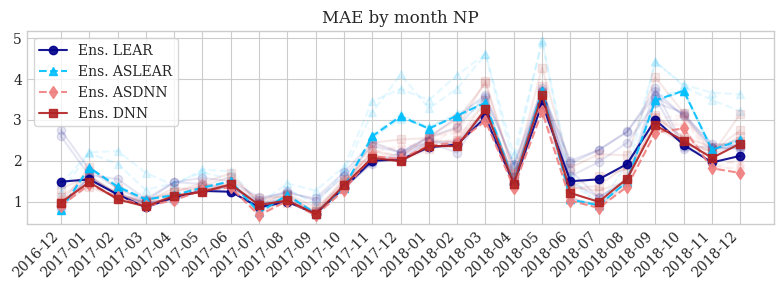

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.1
        label_value = '_no_legend_'
        
    if model != 'LEAR_all_ensemble' and model != 'DNN_all_ensemble':
        ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':6})
ax.legend(frameon=True)
ax.title.set_text("MAE by month NP")
ax.title.set_size(12)
fig.autofmt_xdate(rotation=45)
plt.tight_layout()

In [151]:
fig.savefig("mae_by_month_np.png", dpi=300)

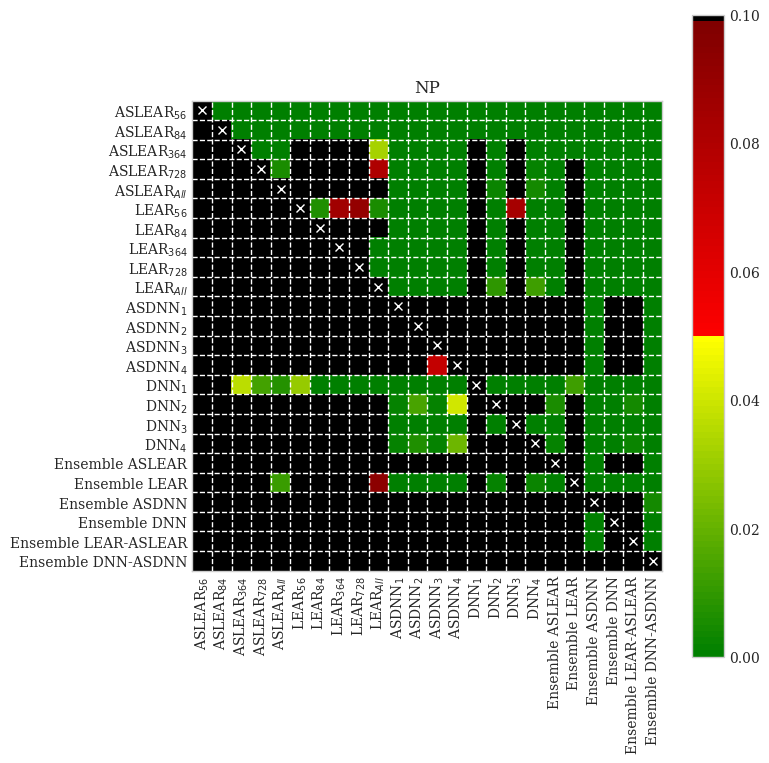

In [152]:
models = [col for col in dict_datastets_forecasts['NP.csv'] if col not in ['Date', 'Price']]
df_aux = dict_datastets_forecasts['NP.csv'][models]
df_aux.columns = models_dm
plot_multivariate_DM_test(dict_datastets_forecasts['NP.csv'].Price, 
                          df_aux, 
                          norm=1, 
                          title='NP', 
                          savefig=True, 
                          path=r'C:\Users\csebastian\Desktop\CARIBE')

# LARS

In [7]:
dict_datastets_forecasts = {}

datasets = ["SP_2023.csv", "DE_2023.csv", "BE.csv", "FR.csv", "NP.csv"]
apply_adaptive_standardisation_list = [True, False]
calibration_windows_1 = [1092, 1456]
calibration_windows_2 = [364, 728]
models = ['LEAR']

for dataset in datasets:
    df = pd.read_csv(f"Data//{dataset}")
    df['Date'] = pd.to_datetime(df.Date)
    if '_no_outliers' not in dataset:
        df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2']
        df = df.drop(['Exogenous 1', 'Exogenous 2'], axis = 1)
    else:
        df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Price']
        df = df.drop(['Exogenous 1', 'Exogenous 2', 'Price'], axis = 1)
    for model in models:
        if dataset in ["BE.csv", "FR.csv", "NP.csv"]:
            if model =='LEAR':
                calibration_windows = calibration_windows_1
            else:
                calibration_windows = experiment_ids
        elif dataset in ["DE_2023.csv", "SP_2023.csv"]:
            if model =='LEAR':
                calibration_windows = calibration_windows_2
            else:
                calibration_windows = experiment_ids

        if dataset in ["BE.csv", "FR.csv"]:
            begin_test_date = "04/01/2015 00:00"
            end_test_date = "31/12/2016 23:00"

        elif dataset in ["DE_2023.csv", "SP_2023.csv"] :
            begin_test_date = "01/01/2022 00:00"
            end_test_date = "31/05/2023 23:00"

        elif dataset in ["NP.csv"] :
            begin_test_date = "27/12/2016 00:00"
            end_test_date = "24/12/2018 23:00"


        for apply_adaptive_standardisation in apply_adaptive_standardisation_list:
            for calibration_window in calibration_windows:
                if apply_adaptive_standardisation:
                    if model == "LEAR":
                        file_name = f"dataset_{dataset.replace('.csv', '_no_outliers')}_larsmodel_LEAR_as_calibration_window{calibration_window}.csv"
                    else:
                        file_name = f"dataset_{dataset.replace('.csv', '')}model_DNN_as_calibration_window_None_experiment_id_{calibration_window}.csv"        
                else:
                    if model == "LEAR":
                        file_name = f"dataset_{dataset.replace('.csv', '')}_larsmodel_LEAR_calibration_window{calibration_window}.csv"
                    else:
                        if dataset in ["BE.csv", "FR.csv", "NP.csv"]:
                            file_name = f"dataset_{dataset.replace('.csv', '')}model_DNN_calibration_window_4_experiment_id_{calibration_window}.csv"
                        else:
                            file_name = f"dataset_{dataset.replace('.csv', '')}model_DNN_calibration_window_3_experiment_id_{calibration_window}.csv"
                try:
                    forecasts = pd.read_csv("Results_py//"+file_name, index_col=0).to_numpy().reshape(-1)
                    if model == 'LEAR':
                        df.loc[df.tail(len(forecasts)).index, f'{"LEAR"}_calibration_window_{str(calibration_window).replace("_", "")}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                    else:
                        if apply_adaptive_standardisation:
                            df.loc[df.tail(len(forecasts)).index, f'{"DNN"}_calibration_window_None_experiment_id_{str(calibration_window)}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                        else:
                            if dataset in ["BE.csv", "FR.csv", "NP.csv"]:
                                df.loc[df.tail(len(forecasts)).index, f'{"DNN"}_calibration_window_4_experiment_id_{str(calibration_window)}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                            else:
                                df.loc[df.tail(len(forecasts)).index, f'{"DNN"}_calibration_window_3_experiment_id_{str(calibration_window)}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
                except:
                    pass
            if apply_adaptive_standardisation and model == 'LEAR':
                file_name = f"dataset_{dataset.replace('.csv', '_no_outliers')}_larsmodel_LEAR_as_calibration_window_{None}.csv"
    #             try:
                forecasts = pd.read_csv("Results_py//"+file_name, index_col=0).to_numpy().reshape(-1)
    #             except:
    #                 print(file_name)
    #                 forecasts = pd.read_csv(r"C:\Users\csebastian\Desktop\CARIBE\Results_py\dataset_NPmodel_LEAR_as_calibration_window_None.csv", index_col=0).to_numpy().reshape(-1)
                df.loc[df.tail(len(forecasts)).index, f'{"LEAR"}_calibration_window_{str(None).replace("_", "")}_adaptive_standardisation_{apply_adaptive_standardisation}'] = forecasts
#                 except:
#                     pass
#     columns_ensemble_1_LEAR = [col for col in df.columns if ('True' in col and 'LEAR' in col)]
#     columns_ensemble_2_LEAR = [col for col in df.columns if ('False' in col and 'LEAR' in col)]

#     df['LEAR_ensemble_adaptive_standardisation_True'] = df[columns_ensemble_1_LEAR].mean(axis=1)
#     df['LEAR_ensemble_adaptive_standardisation_False'] = df[columns_ensemble_2_LEAR].mean(axis=1)

#     columns_ensemble_1_DNN = [col for col in df.columns if ('True' in col and 'DNN' in col)]
#     columns_ensemble_2_DNN = [col for col in df.columns if ('False' in col and 'DNN' in col)]

#     df['DNN_ensemble_adaptive_standardisation_True'] = df[columns_ensemble_1_DNN].mean(axis=1)
#     df['DNN_ensemble_adaptive_standardisation_False'] = df[columns_ensemble_2_DNN].mean(axis=1)

    dict_datastets_forecasts[dataset] = df.dropna()
    
        
        

In [8]:
dict_datasets_results={}
for dataset in datasets:
# for dataset in ['SP_2023.csv']:
    df = dict_datastets_forecasts[dataset]
    models = [col for col in df.columns if col not in ['Date', 'Price']]
    dict_datasets_results[dataset] = pd.DataFrame(columns= models)
    
    real_values = df.set_index(pd.DatetimeIndex(df.Date)).loc[:, ['Price']].values.reshape(-1, 24)
    real_values = pd.DataFrame(real_values, index=pd.DatetimeIndex(df.Date)[::24], columns=['h' + str(k) for k in range(24)])
    
    maes = []
    rmses = []
    smapes = []
    rmaes = []
    
    for model in models:
        
        forecasts_matrix = df.set_index(pd.DatetimeIndex(df.Date)).loc[:, [model]].values.reshape(-1, 24)
        forecasts_matrix = pd.DataFrame(forecasts_matrix, index=pd.DatetimeIndex(df.Date)[::24], columns=['h' + str(k) for k in range(24)])
        
        maes.append(MAE(df.Price, df[model]))
        rmses.append(RMSE(df.Price, df[model]))
        smapes.append(sMAPE(df.Price, df[model]))
        rmaes.append(rMAE(real_values, forecasts_matrix, m='W'))
    
    dict_datasets_results[dataset].loc['MAE', :] = maes
    dict_datasets_results[dataset].loc['RMSE', :] = rmses
    dict_datasets_results[dataset].loc['sMAPE', :] = smapes
    dict_datasets_results[dataset].loc['rMAE', :] = rmaes

In [9]:
pd.set_option('display.max_columns', 21)

# OMIE-SP

In [11]:
dict_datasets_results['SP_2023.csv']

,LEAR_calibration_window_364_adaptive_standardisation_True,LEAR_calibration_window_728_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_364_adaptive_standardisation_False,LEAR_calibration_window_728_adaptive_standardisation_False
MAE,18.713285,18.366905,18.42435,20.887041,20.810328
RMSE,26.911288,26.214401,26.109308,29.775093,29.031098
sMAPE,0.211586,0.21047,0.216627,0.231961,0.229495
rMAE,0.488661,0.479616,0.481116,0.545424,0.543421


In [15]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['SP_2023.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['SP_2023.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['SP_2023.csv'][dict_datastets_forecasts['SP_2023.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


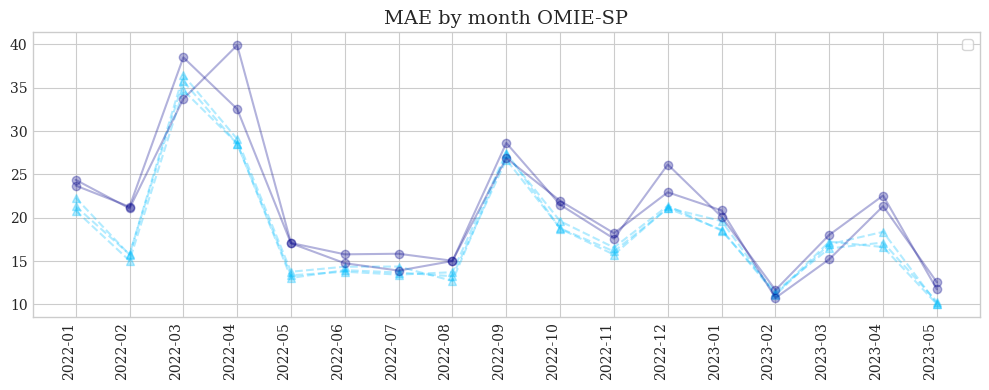

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.3
        label_value = '_no_legend_'
        
    
    ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':10})
ax.legend(frameon=True)
ax.title.set_text("MAE by month OMIE-SP")
ax.title.set_size(14)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()

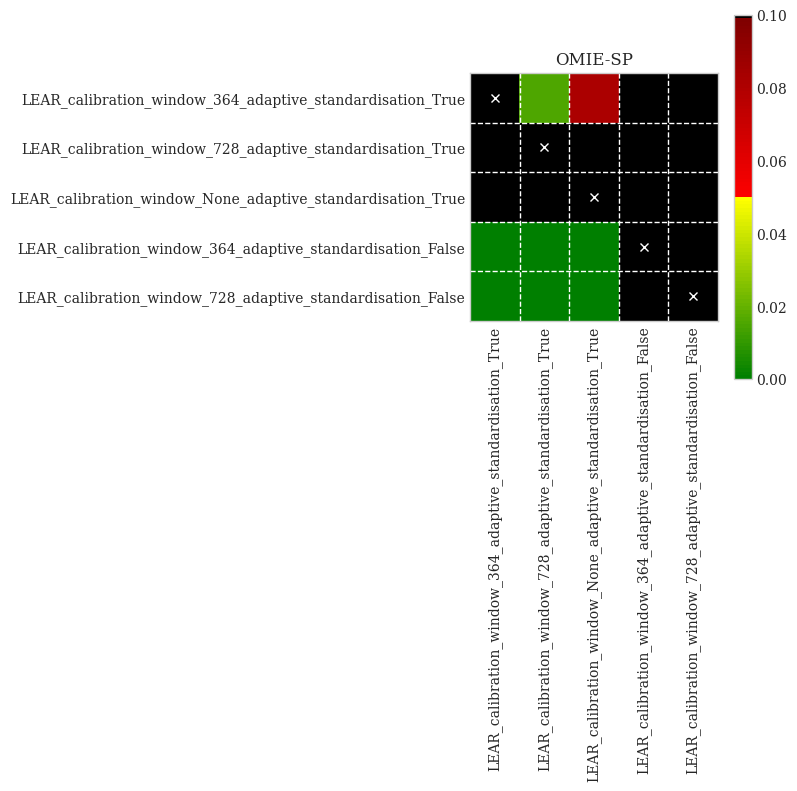

In [17]:
models = [col for col in dict_datastets_forecasts['SP_2023.csv'] if col not in ['Date', 'Price']]
plot_multivariate_DM_test(dict_datastets_forecasts['SP_2023.csv'].Price, 
                          dict_datastets_forecasts['SP_2023.csv'][models], 
                          norm=1, 
                          title='OMIE-SP', 
                          savefig=False, 
                          path='')


# EPEX-DE

In [18]:
dict_datasets_results['DE_2023.csv']

,LEAR_calibration_window_364_adaptive_standardisation_True,LEAR_calibration_window_728_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_364_adaptive_standardisation_False,LEAR_calibration_window_728_adaptive_standardisation_False
MAE,25.706526,25.061662,24.862473,31.775781,30.330631
RMSE,38.29569,37.479921,36.874019,43.775444,43.225748
sMAPE,0.219926,0.212611,0.211939,0.263291,0.236834
rMAE,0.356964,0.348009,0.345243,0.441242,0.421174


In [19]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['DE_2023.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['DE_2023.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['DE_2023.csv'][dict_datastets_forecasts['DE_2023.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


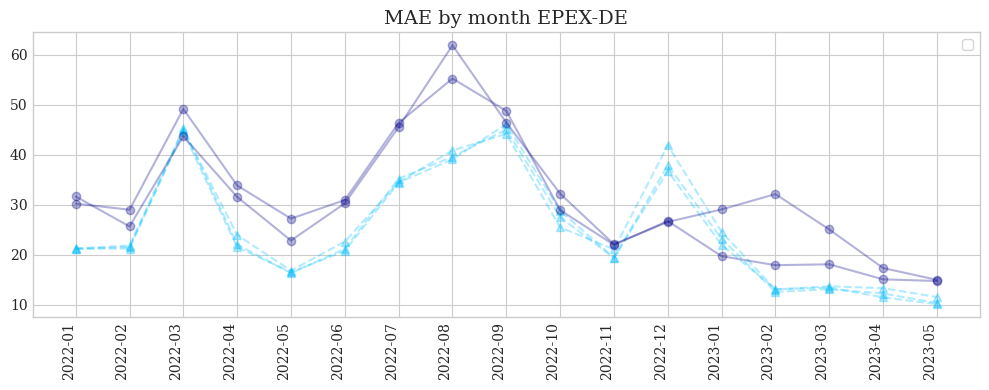

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.3
        label_value = '_no_legend_'
        
    
    ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':10})
ax.legend(frameon=True)
ax.title.set_text("MAE by month EPEX-DE")
ax.title.set_size(14)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()

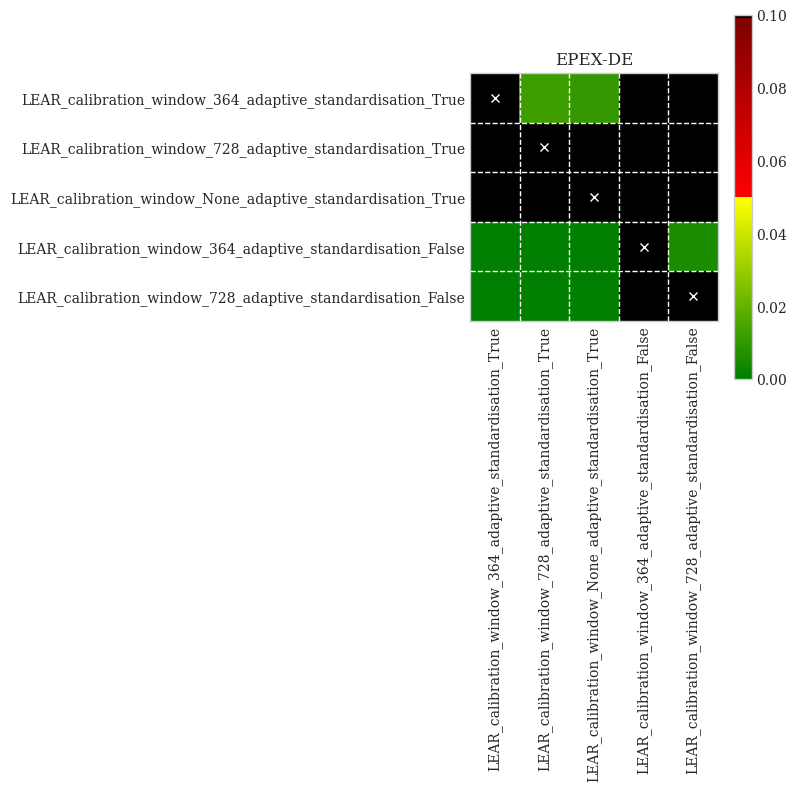

In [21]:
models = [col for col in dict_datastets_forecasts['DE_2023.csv'] if col not in ['Date', 'Price']]
plot_multivariate_DM_test(dict_datastets_forecasts['DE_2023.csv'].Price, 
                          dict_datastets_forecasts['DE_2023.csv'][models], 
                          norm=1, 
                          title='EPEX-DE', 
                          savefig=False, 
                          path='')

# EPEX-BE

In [22]:
dict_datasets_results["BE.csv"]

,LEAR_calibration_window_1092_adaptive_standardisation_True,LEAR_calibration_window_1456_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_1092_adaptive_standardisation_False,LEAR_calibration_window_1456_adaptive_standardisation_False
MAE,6.930377,6.902216,6.940634,6.402572,6.515419
RMSE,17.449323,17.30678,17.40339,16.38989,16.376598
sMAPE,0.15855,0.158102,0.158646,0.159494,0.166733
rMAE,0.682158,0.679386,0.683168,0.630206,0.641314


In [23]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['BE.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['BE.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['BE.csv'][dict_datastets_forecasts['BE.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


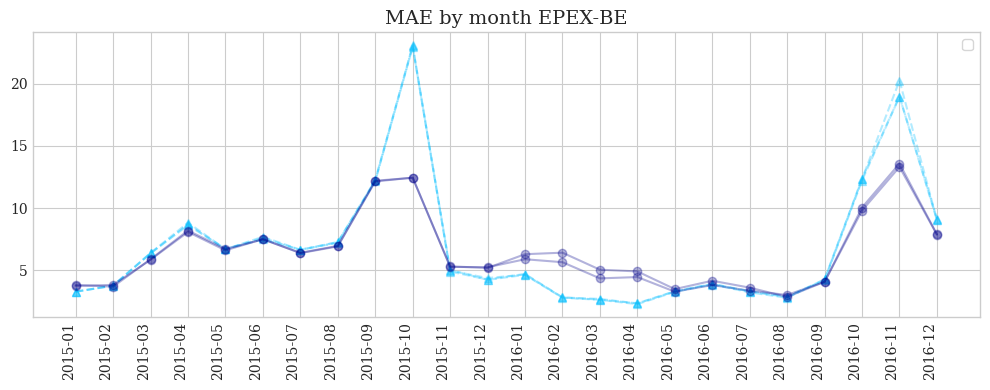

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.3
        label_value = '_no_legend_'
        
    
    ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':10})
ax.legend(frameon=True)
ax.title.set_text("MAE by month EPEX-BE")
ax.title.set_size(14)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()

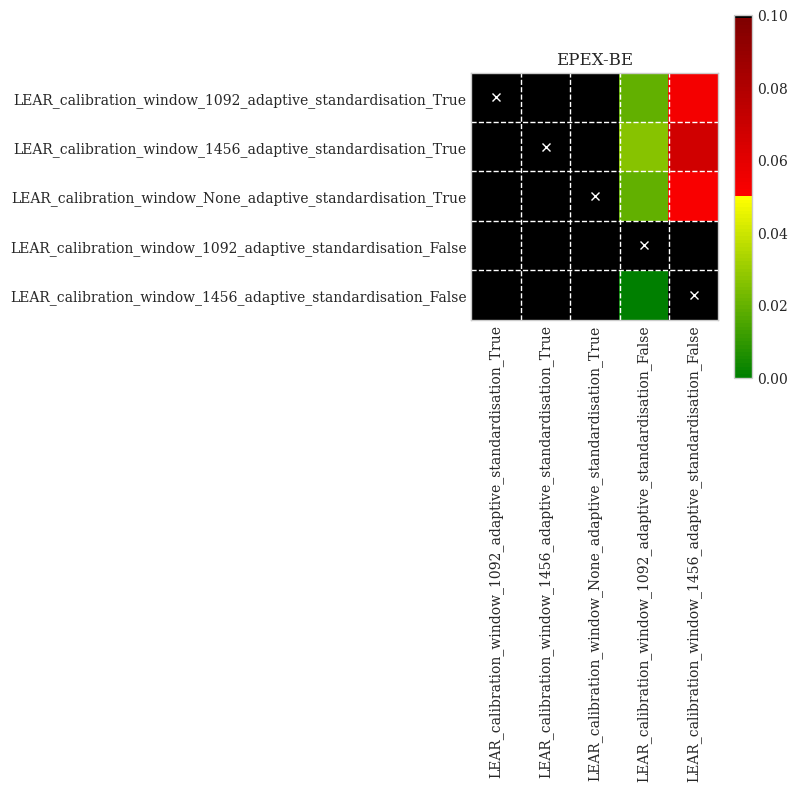

In [25]:
models = [col for col in dict_datastets_forecasts['BE.csv'] if col not in ['Date', 'Price']]
plot_multivariate_DM_test(dict_datastets_forecasts['BE.csv'].Price, 
                          dict_datastets_forecasts['BE.csv'][models], 
                          norm=1, 
                          title='EPEX-BE', 
                          savefig=False, 
                          path='')

# EPEX-FR

In [26]:
dict_datasets_results["FR.csv"]

,LEAR_calibration_window_1092_adaptive_standardisation_True,LEAR_calibration_window_1456_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_1092_adaptive_standardisation_False,LEAR_calibration_window_1456_adaptive_standardisation_False
MAE,4.214222,4.20126,4.294882,4.265198,4.391835
RMSE,12.578572,12.542304,13.227829,11.628026,11.579723
sMAPE,0.116771,0.116249,0.116064,0.132286,0.142179
rMAE,0.574804,0.573036,0.585806,0.581757,0.59903


In [27]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['FR.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['FR.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['FR.csv'][dict_datastets_forecasts['FR.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


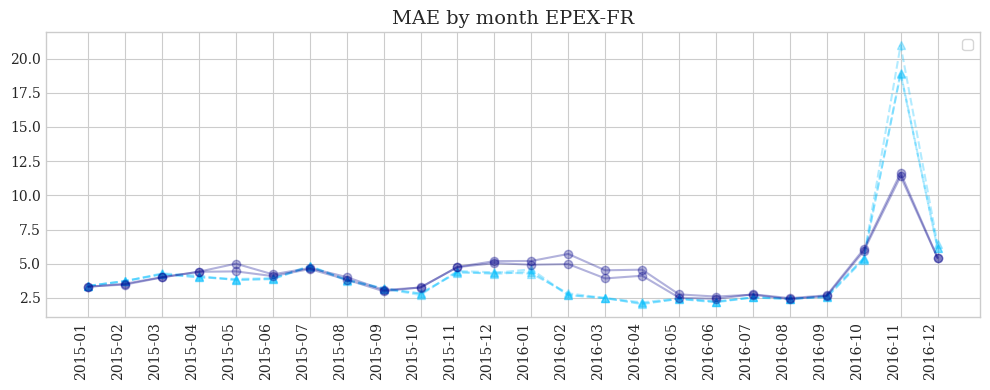

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.3
        label_value = '_no_legend_'
        
    
    ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':10})
ax.legend(frameon=True)
ax.title.set_text("MAE by month EPEX-FR")
ax.title.set_size(14)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()

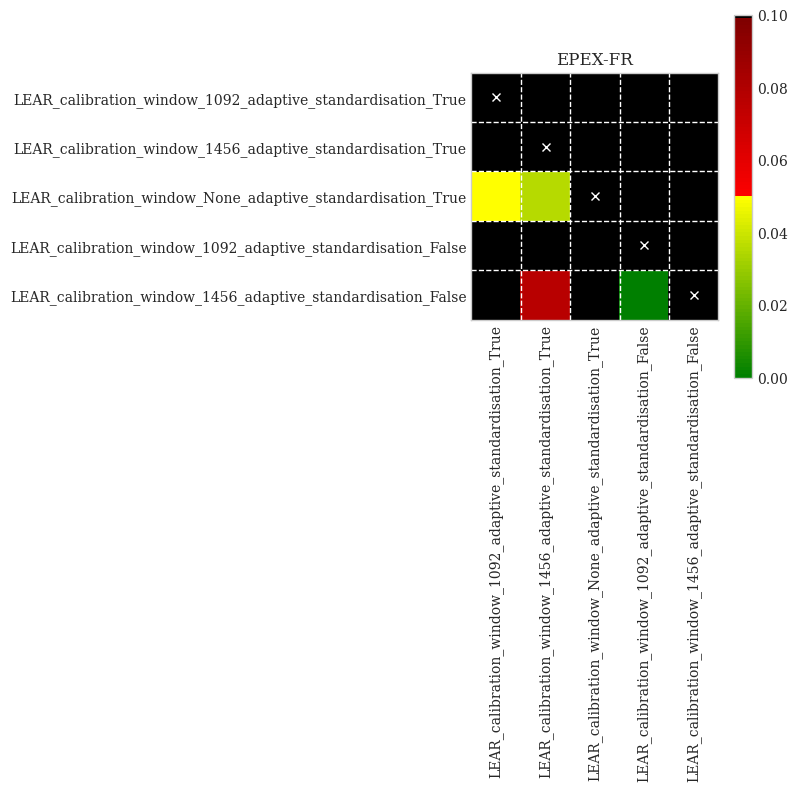

In [29]:
models = [col for col in dict_datastets_forecasts['FR.csv'] if col not in ['Date', 'Price']]
plot_multivariate_DM_test(dict_datastets_forecasts['FR.csv'].Price, 
                          dict_datastets_forecasts['FR.csv'][models], 
                          norm=1, 
                          title='EPEX-FR', 
                          savefig=False, 
                          path='')

# NP

In [30]:
dict_datasets_results["NP.csv"]

,LEAR_calibration_window_1092_adaptive_standardisation_True,LEAR_calibration_window_1456_adaptive_standardisation_True,LEAR_calibration_window_None_adaptive_standardisation_True,LEAR_calibration_window_1092_adaptive_standardisation_False,LEAR_calibration_window_1456_adaptive_standardisation_False
MAE,2.023937,2.004116,2.000275,2.073376,2.057876
RMSE,3.869451,3.853689,3.849866,3.722955,3.69686
sMAPE,0.0592,0.058751,0.058619,0.058488,0.058078
rMAE,0.489499,0.484705,0.483776,0.501456,0.497707


In [31]:
dict_maes_by_month = {model:[] for model in dict_datastets_forecasts['NP.csv'].columns if model not in ['Date', 'Price']}
labels = []
for year in sorted(dict_datastets_forecasts['NP.csv'].Date.dt.year.unique()):
    df_year = dict_datastets_forecasts['NP.csv'][dict_datastets_forecasts['NP.csv'].Date.dt.year == year]
    for month in sorted(df_year.Date.dt.month.unique()):
        df_month = df_year[df_year.Date.dt.month == month]
        labels.append(str(year) + "-" + "0" * (2-len(str(month))) + str(month))
        for model in df_month.columns:
            if model not in ['Date', 'Price']:
                dict_maes_by_month[model].append(MAE(df_month.Price, df_month[model]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


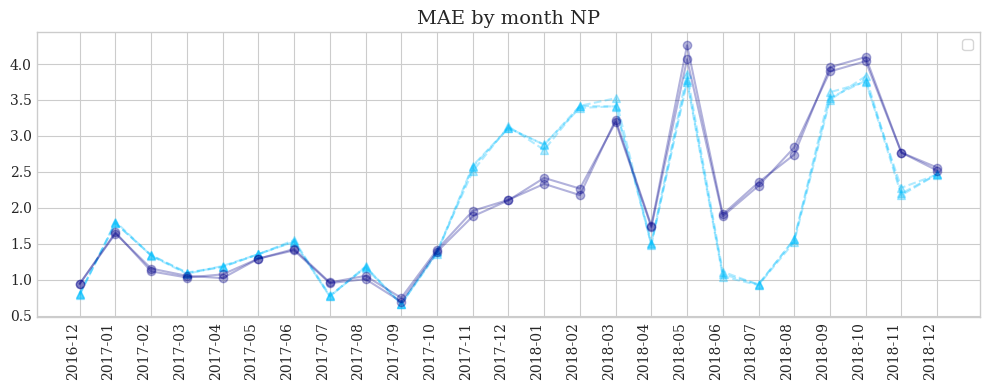

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for model in dict_maes_by_month.keys():
    if 'DNN' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[1]
            marker_value = markers[1]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[3]
            marker_value = markers[3]
    elif 'LEAR' in model:
        if 'False' in model:
            linestyle_value = linestyles[0]
            color_value = colors_css[0]
            marker_value = markers[0]
        elif 'True' in model:
            linestyle_value = linestyles[1]
            color_value = colors_css[2]
            marker_value = markers[2]
    
    if 'ensemble' in model:
        alpha_value = 0.9
        if 'DNN' in model:
            if 'True' in model:
                label_value = 'Ens. ASDNN'
            else:
                label_value = 'Ens. DNN'
        else:
            if 'True' in model:
                label_value = 'Ens. ASLEAR'
            else:
                label_value = 'Ens. LEAR'
    else:
        alpha_value = 0.3
        label_value = '_no_legend_'
        
    
    ax.plot(labels, dict_maes_by_month[model], linestyle_value, label=label_value, alpha = alpha_value, marker=marker_value, color=color_value)
ax.legend(prop={'size':10})
ax.legend(frameon=True)
ax.title.set_text("MAE by month NP")
ax.title.set_size(14)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()

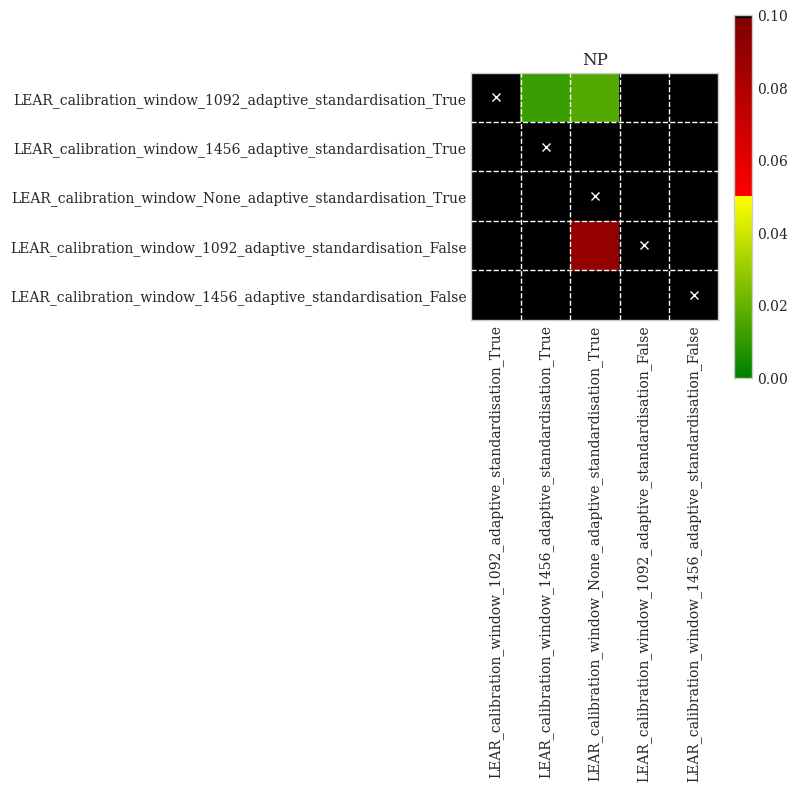

In [33]:
models = [col for col in dict_datastets_forecasts['NP.csv'] if col not in ['Date', 'Price']]
plot_multivariate_DM_test(dict_datastets_forecasts['NP.csv'].Price, 
                          dict_datastets_forecasts['NP.csv'][models], 
                          norm=1, 
                          title='NP', 
                          savefig=False, 
                          path='')